In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import unicodedata
import re

# -------------------------------
# 1. Lấy HTML page
# -------------------------------
url = "https://en.wikipedia.org/w/index.php?title=List_of_Falcon_9_and_Falcon_Heavy_launches&oldid=1027686922"
headers = {"User-Agent": "Mozilla/5.0"}
response = requests.get(url, headers=headers)
soup = BeautifulSoup(response.text, 'html.parser')

# -------------------------------
# 2. Các hàm hỗ trợ
# -------------------------------
def date_time(table_cell):
    """Trả về [date, time] từ cell"""
    return [data_time.strip() for data_time in list(table_cell.strings)][0:2]

def booster_version(table_cell):
    """Trả về booster version"""
    out=''.join([v for i,v in enumerate(table_cell.strings) if i%2==0][0:-1])
    return out.strip()

def landing_status(table_cell):
    """Trả về landing status"""
    strings_list = list(table_cell.strings)
    return strings_list[0].strip() if strings_list else ''

def get_mass(table_cell):
    mass = unicodedata.normalize("NFKD", table_cell.text).strip()
    if "kg" in mass:
        new_mass = mass[:mass.find("kg")+2]
    else:
        new_mass = mass
    return new_mass

def get_cell_text(cell):
    """Lấy text an toàn từ cell, ưu tiên <a>"""
    if cell.a:
        return cell.a.text.strip()
    else:
        return cell.text.strip()

# -------------------------------
# 3. Khởi tạo launch_dict
# -------------------------------
columns = ['Flight No.', 'Date', 'Time', 'Version Booster', 'Launch Site', 
           'Payload', 'Payload mass', 'Orbit', 'Customer', 'Launch outcome', 'Booster landing']
launch_dict = {col: [] for col in columns}

# -------------------------------
# 4. Loop qua tất cả table và row
# -------------------------------
for table in soup.find_all('table', class_="wikitable plainrowheaders collapsible"):
    for row in table.find_all('tr'):
        # Chỉ xử lý row có Flight No.
        if row.th and row.th.string and row.th.string.strip().isdigit():
            flight_no = row.th.string.strip()
            
            # Lấy tất cả td
            cells = row.find_all('td')
            
            # Bỏ qua row không đủ 9+ cells
            if len(cells) < 9:
                continue
            
            # Date & Time
            dt_list = date_time(cells[0])
            date = dt_list[0].strip(',') if len(dt_list) > 0 else ''
            time = dt_list[1] if len(dt_list) > 1 else ''
            
            # Booster version
            bv = booster_version(cells[1])
            if not bv:
                bv = get_cell_text(cells[1])
            
            # Launch Site
            launch_site = get_cell_text(cells[2])
            
            # Payload
            payload = get_cell_text(cells[3])
            
            # Payload Mass
            payload_mass = get_mass(cells[4])
            
            # Orbit
            orbit = get_cell_text(cells[5])
            
            # Customer
            customer = get_cell_text(cells[6])
            
            # Launch outcome
            launch_outcome = landing_status(cells[7])
            
            # Booster landing
            booster_landing = landing_status(cells[8])
            
            # Append vào dict
            launch_dict['Flight No.'].append(flight_no)
            launch_dict['Date'].append(date)
            launch_dict['Time'].append(time)
            launch_dict['Version Booster'].append(bv)
            launch_dict['Launch Site'].append(launch_site)
            launch_dict['Payload'].append(payload)
            launch_dict['Payload mass'].append(payload_mass)
            launch_dict['Orbit'].append(orbit)
            launch_dict['Customer'].append(customer)
            launch_dict['Launch outcome'].append(launch_outcome)
            launch_dict['Booster landing'].append(booster_landing)

# -------------------------------
# 5. Tạo DataFrame
# -------------------------------
df_wiki = pd.DataFrame(launch_dict)

# Kiểm tra 5 hàng đầu
print(df_wiki.head())

# -------------------------------
# 6. Lọc Falcon 9 & đếm missing Booster landing
# -------------------------------
df_falcon9 = df_wiki[df_wiki['Version Booster'].str.contains('F9', case=False, na=False)]
num_falcon9 = df_falcon9.shape[0]
num_missing_payload = df_falcon9['Payload mass'].isna().sum() + (df_falcon9['Payload mass'].str.strip() == '').sum()

print("Number of Falcon 9 launches:", num_falcon9)
print("Number of missing Booster landing values:", num_missing_payload)


  Flight No.             Date   Time   Version Booster Launch Site  \
0          1      4 June 2010  18:45  F9 v1.07B0003.18       CCAFS   
1          2  8 December 2010  15:43  F9 v1.07B0004.18       CCAFS   
2          3      22 May 2012  07:44  F9 v1.07B0005.18       CCAFS   
3          4   8 October 2012  00:35  F9 v1.07B0006.18       CCAFS   
4          5     1 March 2013  15:10  F9 v1.07B0007.18       CCAFS   

                                Payload Payload mass Orbit Customer  \
0  Dragon Spacecraft Qualification Unit                LEO   SpaceX   
1                                Dragon                LEO     NASA   
2                                Dragon       525 kg   LEO     NASA   
3                          SpaceX CRS-1     4,700 kg   LEO     NASA   
4                          SpaceX CRS-2     4,877 kg   LEO     NASA   

  Launch outcome Booster landing  
0        Success         Failure  
1        Success         Failure  
2        Success      No attempt  
3        Suc

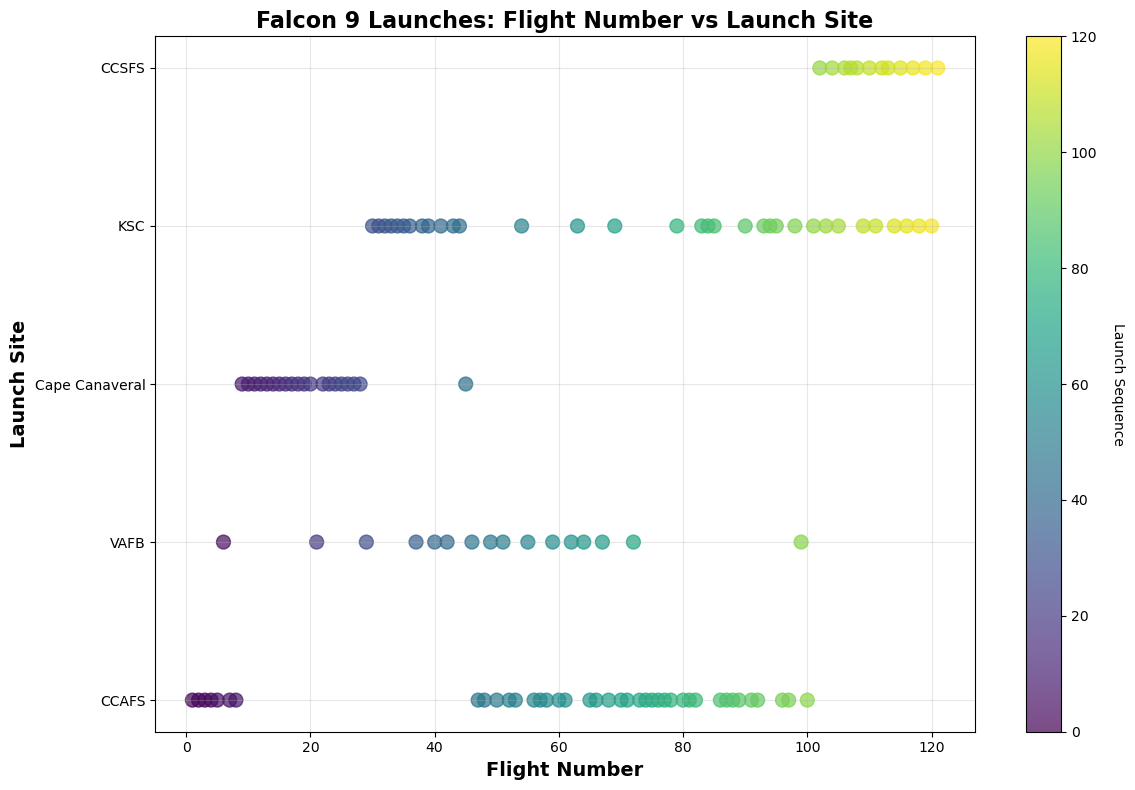

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# 7. Chuẩn bị dữ liệu cho scatter plot
# -------------------------------

# Chuyển Flight No. thành số
df_falcon9['Flight No.'] = pd.to_numeric(df_falcon9['Flight No.'], errors='coerce')

# Lọc bỏ các giá trị không hợp lệ
df_plot = df_falcon9.dropna(subset=['Flight No.', 'Launch Site'])
df_plot = df_plot[df_plot['Flight No.'] > 0]

# -------------------------------
# 8. Vẽ scatter plot
# -------------------------------

plt.figure(figsize=(12, 8))
scatter = plt.scatter(x=df_plot['Flight No.'], 
                      y=df_plot['Launch Site'],
                      alpha=0.7,
                      s=100,  # Kích thước điểm
                      c=range(len(df_plot)),  # Màu theo thứ tự
                      cmap='viridis')

plt.xlabel('Flight Number', fontsize=14, fontweight='bold')
plt.ylabel('Launch Site', fontsize=14, fontweight='bold')
plt.title('Falcon 9 Launches: Flight Number vs Launch Site', fontsize=16, fontweight='bold')

# Thêm colorbar để hiển thị trình tự thời gian
cbar = plt.colorbar(scatter)
cbar.set_label('Launch Sequence', rotation=270, labelpad=20)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

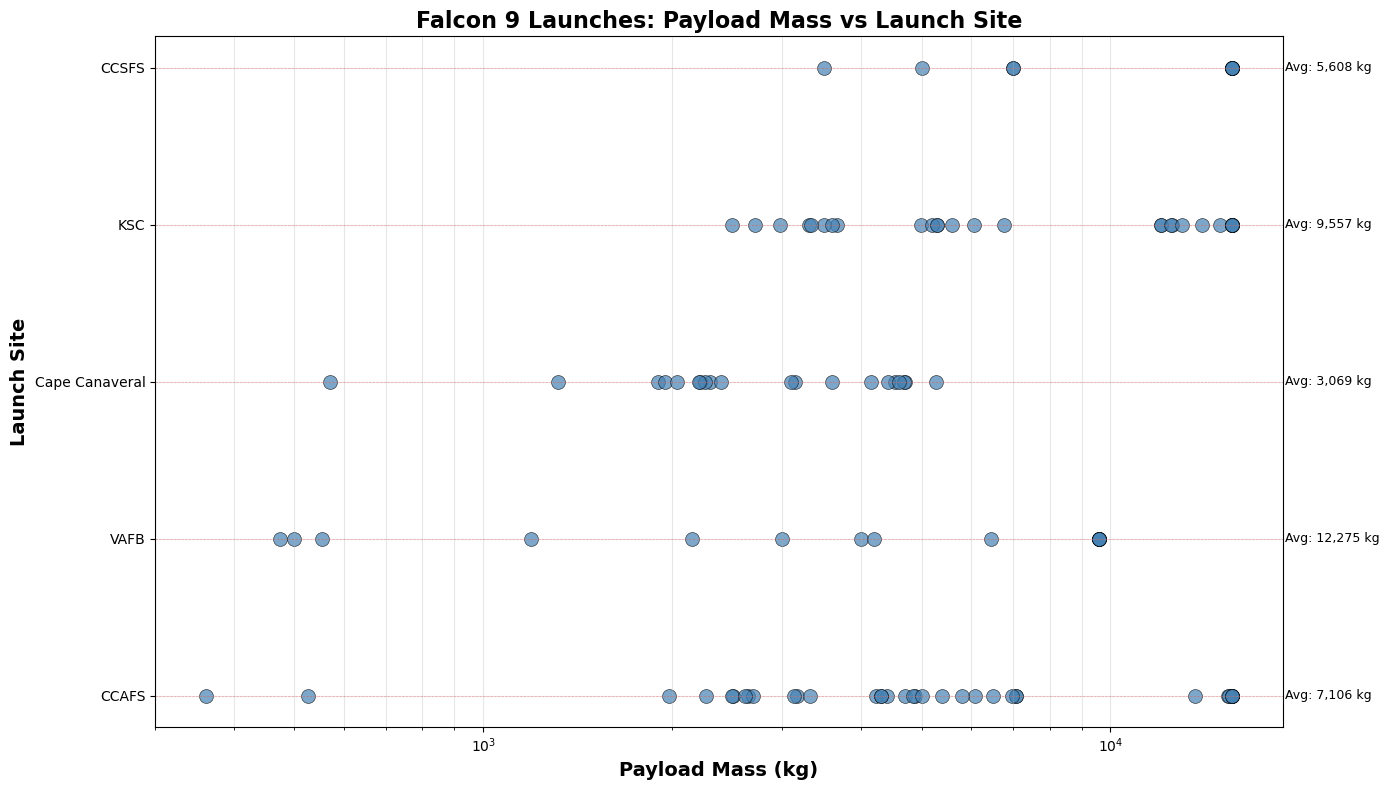


PAYLOAD MASS STATISTICS BY LAUNCH SITE

CCAFS:
  Number of launches: 37
  Min payload mass: 362 kg
  Max payload mass: 15,600 kg
  Avg payload mass: 7,106 kg
  Total payload mass: 262,929 kg

CCSFS:
  Number of launches: 12
  Min payload mass: 3,500 kg
  Max payload mass: 15,600 kg
  Avg payload mass: 12,275 kg
  Total payload mass: 147,300 kg

Cape Canaveral:
  Number of launches: 20
  Min payload mass: 570 kg
  Max payload mass: 5,271 kg
  Avg payload mass: 3,069 kg
  Total payload mass: 61,371 kg

KSC:
  Number of launches: 31
  Min payload mass: 2,490 kg
  Max payload mass: 15,600 kg
  Avg payload mass: 9,557 kg
  Total payload mass: 296,265 kg

VAFB:
  Number of launches: 16
  Min payload mass: 475 kg
  Max payload mass: 9,600 kg
  Avg payload mass: 5,608 kg
  Total payload mass: 89,730 kg


In [3]:
# -------------------------------
# 7. Vẽ scatter plot Payload vs. Launch Site
# -------------------------------

# Chuẩn bị dữ liệu Payload mass
# Chuyển đổi payload mass thành số (kg)
def extract_numeric_mass(mass_str):
    """Trích xuất số từ payload mass string"""
    if pd.isna(mass_str):
        return None
    # Tìm số trong string (vd: "5,500 kg" -> 5500)
    numbers = re.findall(r'[\d,]+', str(mass_str))
    if numbers:
        # Xóa dấu phẩy và chuyển thành số
        clean_number = numbers[0].replace(',', '')
        try:
            return float(clean_number)
        except:
            return None
    return None

# Áp dụng hàm extract_numeric_mass
df_wiki['Payload mass numeric'] = df_wiki['Payload mass'].apply(extract_numeric_mass)

# Lọc chỉ Falcon 9 và loại bỏ giá trị None
df_falcon9 = df_wiki[df_wiki['Version Booster'].str.contains('F9', case=False, na=False)]
df_plot_payload = df_falcon9.dropna(subset=['Launch Site', 'Payload mass numeric'])
df_plot_payload = df_plot_payload[df_plot_payload['Payload mass numeric'] > 0]

# Vẽ scatter plot
plt.figure(figsize=(14, 8))

# Tạo scatter plot
scatter = plt.scatter(x=df_plot_payload['Payload mass numeric'], 
                      y=df_plot_payload['Launch Site'],
                      alpha=0.7,
                      s=100,
                      c='steelblue',
                      edgecolors='black',
                      linewidth=0.5)

# Định dạng đồ thị
plt.xlabel('Payload Mass (kg)', fontsize=14, fontweight='bold')
plt.ylabel('Launch Site', fontsize=14, fontweight='bold')
plt.title('Falcon 9 Launches: Payload Mass vs Launch Site', fontsize=16, fontweight='bold')

# Định dạng trục x
plt.xscale('log')  # Dùng log scale vì payload mass có range lớn
plt.grid(True, alpha=0.3, which='both')

# Thêm thông tin thống kê
mean_payloads = df_plot_payload.groupby('Launch Site')['Payload mass numeric'].mean()
for i, (site, mean_val) in enumerate(mean_payloads.items()):
    plt.axhline(y=i, color='red', linestyle='--', alpha=0.3, linewidth=0.5)
    plt.text(plt.xlim()[1] * 1.01, i, f'Avg: {mean_val:,.0f} kg', 
             verticalalignment='center', fontsize=9)

plt.tight_layout()
plt.show()

# In thống kê
print("\n" + "="*60)
print("PAYLOAD MASS STATISTICS BY LAUNCH SITE")
print("="*60)

for site in sorted(df_plot_payload['Launch Site'].unique()):
    site_data = df_plot_payload[df_plot_payload['Launch Site'] == site]
    print(f"\n{site}:")
    print(f"  Number of launches: {len(site_data)}")
    print(f"  Min payload mass: {site_data['Payload mass numeric'].min():,.0f} kg")
    print(f"  Max payload mass: {site_data['Payload mass numeric'].max():,.0f} kg")
    print(f"  Avg payload mass: {site_data['Payload mass numeric'].mean():,.0f} kg")
    print(f"  Total payload mass: {site_data['Payload mass numeric'].sum():,.0f} kg")

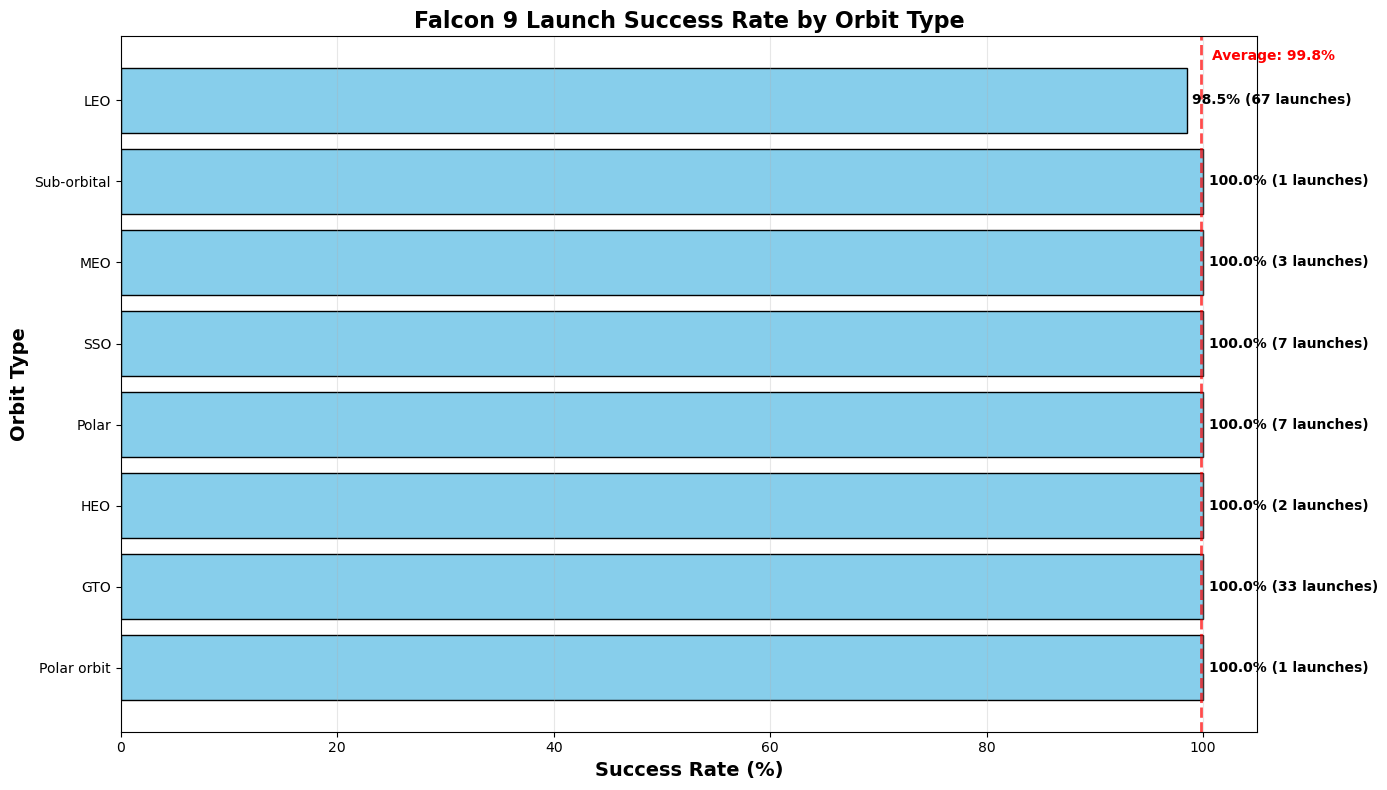


SUCCESS RATE BY ORBIT TYPE - DETAILED STATISTICS
Orbit Type                     Total      Success    Failure    Success Rate   
----------------------------------------------------------------------
Polar orbit                    1          1          0          100.0          %
GTO                            33         33         0          100.0          %
HEO                            2          2          0          100.0          %
Polar                          7          7          0          100.0          %
SSO                            7          7          0          100.0          %
MEO                            3          3          0          100.0          %
Sub-orbital                    1          1          0          100.0          %
LEO                            67         66         1          98.5           %
----------------------------------------------------------------------
OVERALL                        121        120        1          99.8           %

In [4]:
# -------------------------------
# 8. Bar chart cho success rate của mỗi orbit type
# -------------------------------

# Chuẩn bị dữ liệu: Lọc chỉ Falcon 9 và có thông tin orbit/outcome
df_orbit_success = df_wiki[
    df_wiki['Version Booster'].str.contains('F9', case=False, na=False) &
    df_wiki['Orbit'].notna() &
    df_wiki['Launch outcome'].notna()
].copy()

# Tính success rate cho mỗi orbit type
orbit_stats = []
for orbit in df_orbit_success['Orbit'].unique():
    orbit_data = df_orbit_success[df_orbit_success['Orbit'] == orbit]
    total_launches = len(orbit_data)
    if total_launches > 0:
        successful_launches = len(orbit_data[orbit_data['Launch outcome'].str.contains('Success', case=False, na=False)])
        success_rate = (successful_launches / total_launches) * 100
        orbit_stats.append({
            'Orbit': orbit,
            'Total Launches': total_launches,
            'Successful Launches': successful_launches,
            'Success Rate': success_rate
        })

# Tạo DataFrame từ kết quả
df_orbit_stats = pd.DataFrame(orbit_stats)

# Sắp xếp theo success rate giảm dần
df_orbit_stats = df_orbit_stats.sort_values('Success Rate', ascending=False)

# Vẽ bar chart
plt.figure(figsize=(14, 8))

# Tạo bars
bars = plt.barh(df_orbit_stats['Orbit'], df_orbit_stats['Success Rate'], 
                color='skyblue', edgecolor='black')

# Thêm số liệu trên mỗi bar
for i, (rate, total) in enumerate(zip(df_orbit_stats['Success Rate'], df_orbit_stats['Total Launches'])):
    plt.text(rate + 0.5, i, f'{rate:.1f}% ({total} launches)', 
             va='center', fontsize=10, fontweight='bold')

# Định dạng đồ thị
plt.xlabel('Success Rate (%)', fontsize=14, fontweight='bold')
plt.ylabel('Orbit Type', fontsize=14, fontweight='bold')
plt.title('Falcon 9 Launch Success Rate by Orbit Type', fontsize=16, fontweight='bold')
plt.xlim([0, 105])  # Thêm khoảng trống cho text
plt.grid(axis='x', alpha=0.3)

# Thêm đường success rate trung bình
avg_success_rate = df_orbit_stats['Success Rate'].mean()
plt.axvline(x=avg_success_rate, color='red', linestyle='--', linewidth=2, alpha=0.7)
plt.text(avg_success_rate + 1, len(df_orbit_stats)-0.5, 
         f'Average: {avg_success_rate:.1f}%', 
         color='red', fontweight='bold')

plt.tight_layout()
plt.show()

# In bảng thống kê chi tiết
print("\n" + "="*70)
print("SUCCESS RATE BY ORBIT TYPE - DETAILED STATISTICS")
print("="*70)
print(f"{'Orbit Type':<30} {'Total':<10} {'Success':<10} {'Failure':<10} {'Success Rate':<15}")
print("-"*70)

for idx, row in df_orbit_stats.iterrows():
    failures = row['Total Launches'] - row['Successful Launches']
    print(f"{row['Orbit'][:30]:<30} {row['Total Launches']:<10} {row['Successful Launches']:<10} {failures:<10} {row['Success Rate']:<15.1f}%")

print("-"*70)
print(f"{'OVERALL':<30} {df_orbit_stats['Total Launches'].sum():<10} {df_orbit_stats['Successful Launches'].sum():<10} "
      f"{df_orbit_stats['Total Launches'].sum() - df_orbit_stats['Successful Launches'].sum():<10} "
      f"{df_orbit_stats['Success Rate'].mean():<15.1f}%")

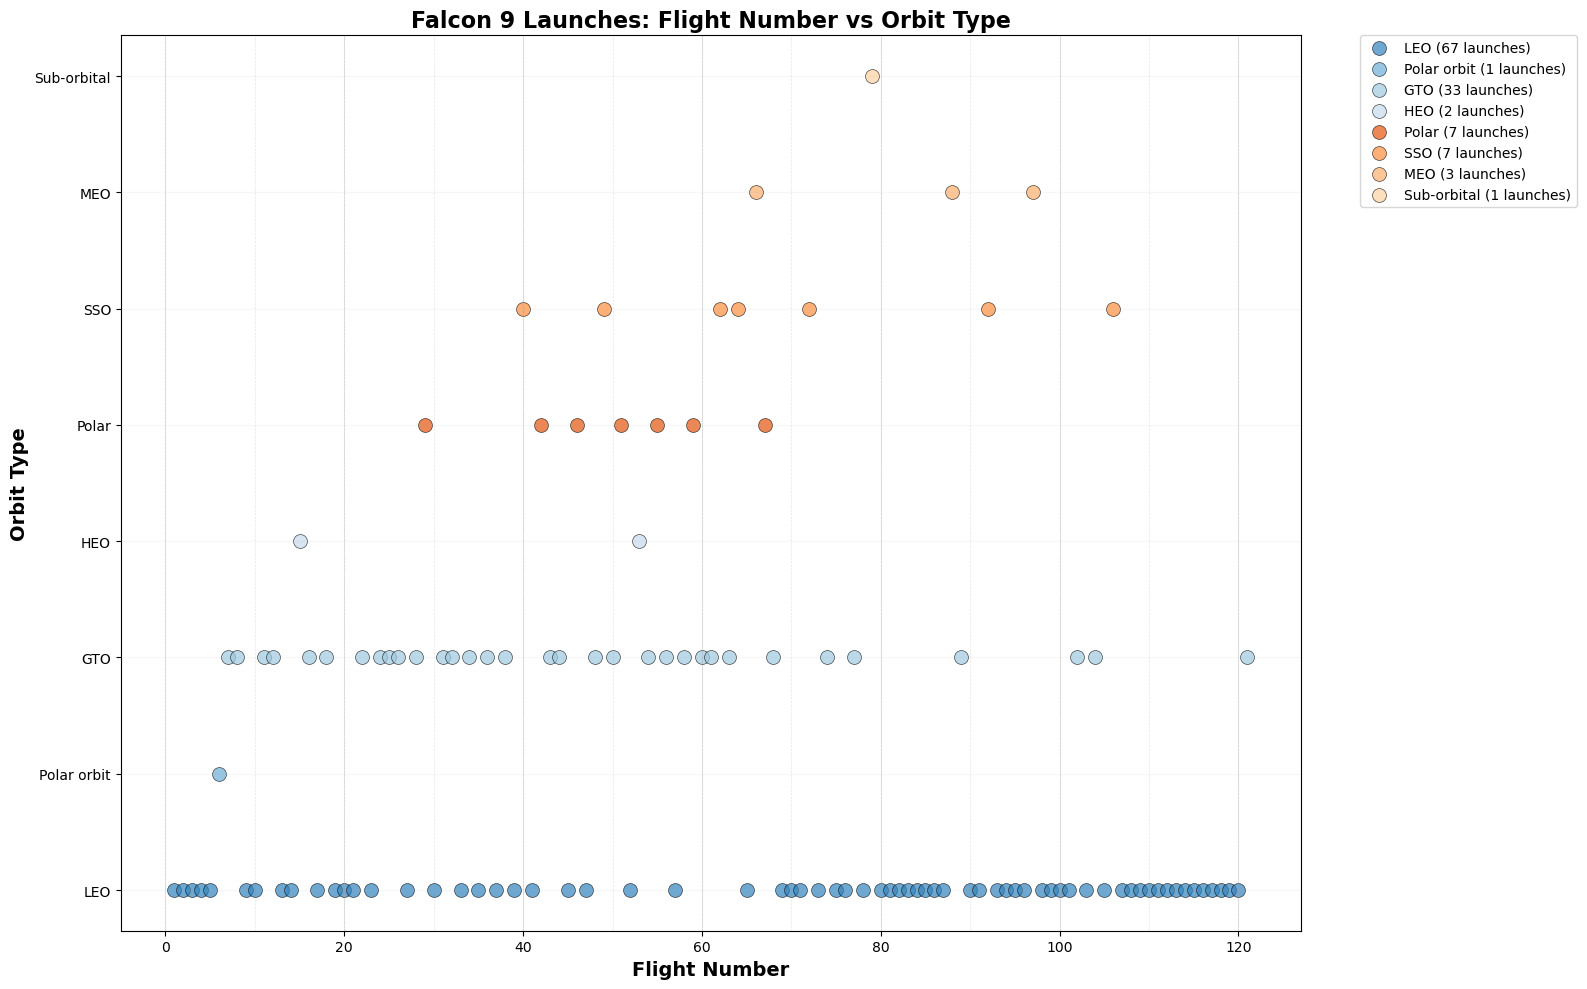


ORBIT TYPE DISTRIBUTION BY FLIGHT NUMBER RANGES

Number of launches by orbit type and flight number range:
Flight Range  1-20  21-40  41-60  61-80  81-100  100+
Orbit                                                
GTO              6     10      8      5       1     3
HEO              1      0      1      0       0     0
LEO             12      8      5      9      16    17
MEO              0      0      0      1       2     0
Polar            0      1      5      1       0     0
Polar orbit      1      0      0      0       0     0
SSO              0      1      1      3       1     1
Sub-orbital      0      0      0      1       0     0

OVERVIEW BY ORBIT TYPE
Orbit Type                     First Flight    Last Flight     Total Launches 
----------------------------------------------------------------------
GTO                            7               121             33             
HEO                            15              53              2              
LEO                 

In [5]:
# -------------------------------
# 9. Scatter plot Flight number vs. Orbit type
# -------------------------------

# Lọc dữ liệu Falcon 9 và có Flight No.
df_flight_orbit = df_wiki[
    df_wiki['Version Booster'].str.contains('F9', case=False, na=False) &
    df_wiki['Flight No.'].notna() &
    df_wiki['Orbit'].notna()
].copy()

# Chuyển Flight No. thành số
df_flight_orbit['Flight No. Numeric'] = pd.to_numeric(df_flight_orbit['Flight No.'], errors='coerce')

# Lọc bỏ giá trị không hợp lệ
df_flight_orbit = df_flight_orbit.dropna(subset=['Flight No. Numeric', 'Orbit'])

# Chuẩn bị màu sắc cho các orbit type
orbit_types = df_flight_orbit['Orbit'].unique()
color_palette = plt.cm.tab20c(range(len(orbit_types)))
color_map = {orbit: color_palette[i] for i, orbit in enumerate(orbit_types)}

# Vẽ scatter plot
plt.figure(figsize=(16, 10))

# Vẽ từng điểm với màu theo orbit type
for orbit, color in color_map.items():
    orbit_data = df_flight_orbit[df_flight_orbit['Orbit'] == orbit]
    plt.scatter(orbit_data['Flight No. Numeric'], 
                [orbit] * len(orbit_data),
                color=color,
                s=100,
                alpha=0.7,
                edgecolors='black',
                linewidth=0.5,
                label=f'{orbit} ({len(orbit_data)} launches)')

# Định dạng đồ thị
plt.xlabel('Flight Number', fontsize=14, fontweight='bold')
plt.ylabel('Orbit Type', fontsize=14, fontweight='bold')
plt.title('Falcon 9 Launches: Flight Number vs Orbit Type', fontsize=16, fontweight='bold')

# Thêm grid
plt.grid(True, alpha=0.3, axis='x')
plt.grid(True, alpha=0.1, axis='y')

# Thêm legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=10)

# Đánh dấu mốc flight number quan trọng (mỗi 10 flights)
max_flight = df_flight_orbit['Flight No. Numeric'].max()
if max_flight > 10:
    for x in range(0, int(max_flight) + 1, 10):
        plt.axvline(x=x, color='gray', linestyle='--', alpha=0.2, linewidth=0.5)

plt.tight_layout()
plt.show()

# In thống kê theo flight number ranges
print("\n" + "="*70)
print("ORBIT TYPE DISTRIBUTION BY FLIGHT NUMBER RANGES")
print("="*70)

# Phân nhóm flight number
df_flight_orbit['Flight Range'] = pd.cut(df_flight_orbit['Flight No. Numeric'], 
                                         bins=[0, 20, 40, 60, 80, 100, float('inf')],
                                         labels=['1-20', '21-40', '41-60', '61-80', '81-100', '100+'])

# Tạo pivot table
pivot_table = pd.pivot_table(df_flight_orbit, 
                             values='Flight No. Numeric', 
                             index='Orbit', 
                             columns='Flight Range', 
                             aggfunc='count', 
                             fill_value=0)

print("\nNumber of launches by orbit type and flight number range:")
print(pivot_table)

# Thống kê tổng hợp
print("\n" + "="*70)
print("OVERVIEW BY ORBIT TYPE")
print("="*70)
print(f"{'Orbit Type':<30} {'First Flight':<15} {'Last Flight':<15} {'Total Launches':<15}")
print("-"*70)

for orbit in sorted(df_flight_orbit['Orbit'].unique()):
    orbit_data = df_flight_orbit[df_flight_orbit['Orbit'] == orbit]
    if len(orbit_data) > 0:
        first_flight = orbit_data['Flight No. Numeric'].min()
        last_flight = orbit_data['Flight No. Numeric'].max()
        total = len(orbit_data)
        print(f"{orbit[:30]:<30} {first_flight:<15.0f} {last_flight:<15.0f} {total:<15}")

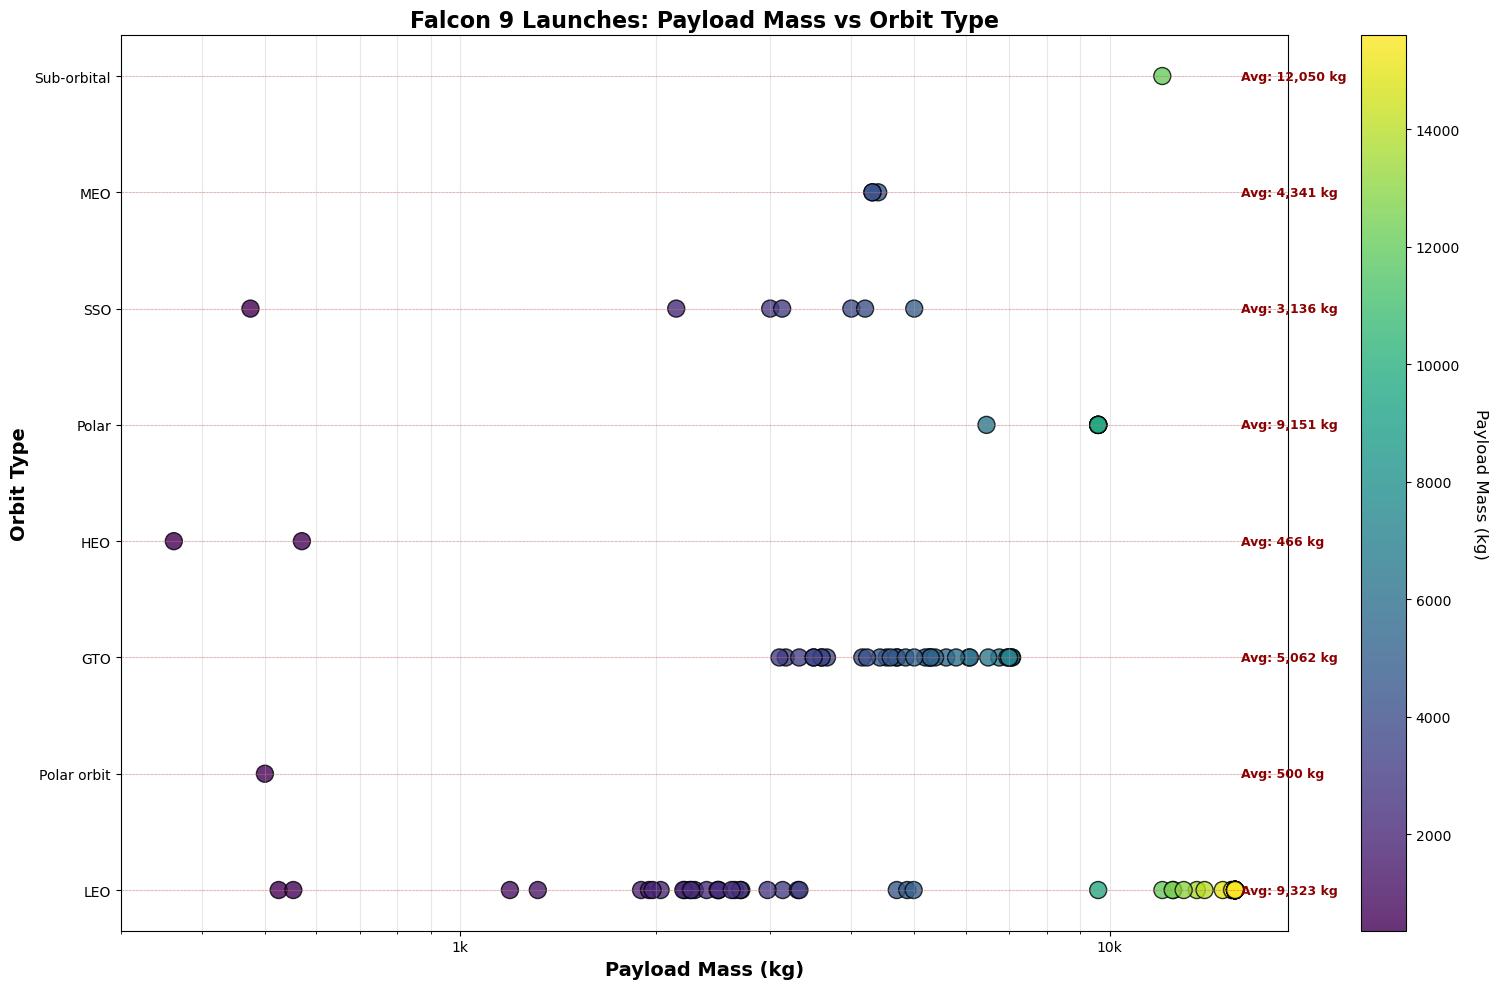


PAYLOAD MASS STATISTICS BY ORBIT TYPE
Orbit Type                          Launches   Min (kg)     Max (kg)     Avg (kg)     Total (kg)  
--------------------------------------------------------------------------------
GTO                                 33         3,100        7,075        5,062        167,038     
HEO                                 2          362          570          466          932         
LEO                                 62         525          15,600       9,323        578,038     
MEO                                 3          4,311        4,400        4,341        13,022      
Polar                               7          6,460        9,600        9,151        64,060      
Polar orbit                         1          500          500          500          500         
SSO                                 7          475          5,000        3,136        21,955      
Sub-orbital                         1          12,050       12,050       12,050       12

In [6]:
# -------------------------------
# 10. Scatter plot Payload vs. Orbit type
# -------------------------------

# Lấy dữ liệu payload mass (sử dụng cột đã được xử lý trước đó)
# Nếu chưa có cột Payload mass numeric, cần tạo lại
if 'Payload mass numeric' not in df_wiki.columns:
    def extract_numeric_mass(mass_str):
        if pd.isna(mass_str):
            return None
        numbers = re.findall(r'[\d,]+', str(mass_str))
        if numbers:
            clean_number = numbers[0].replace(',', '')
            try:
                return float(clean_number)
            except:
                return None
        return None
    
    df_wiki['Payload mass numeric'] = df_wiki['Payload mass'].apply(extract_numeric_mass)

# Lọc dữ liệu Falcon 9 có payload và orbit hợp lệ
df_payload_orbit = df_wiki[
    df_wiki['Version Booster'].str.contains('F9', case=False, na=False) &
    df_wiki['Payload mass numeric'].notna() &
    df_wiki['Orbit'].notna() &
    (df_wiki['Payload mass numeric'] > 0)
].copy()

# Vẽ scatter plot
plt.figure(figsize=(16, 10))

# Tạo colormap cho payload mass
payload_values = df_payload_orbit['Payload mass numeric'].values
norm = plt.Normalize(payload_values.min(), payload_values.max())
cmap = plt.cm.viridis

# Vẽ scatter plot với màu theo payload mass
scatter = plt.scatter(x=df_payload_orbit['Payload mass numeric'],
                      y=df_payload_orbit['Orbit'],
                      c=payload_values,
                      cmap=cmap,
                      s=150,
                      alpha=0.8,
                      edgecolors='black',
                      linewidth=1)

# Thêm colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Payload Mass (kg)', rotation=270, labelpad=20, fontsize=12)

# Tính giá trị trung bình cho mỗi orbit type và thêm đường đánh dấu
orbit_means = df_payload_orbit.groupby('Orbit')['Payload mass numeric'].mean()
for orbit, mean_val in orbit_means.items():
    plt.axhline(y=orbit, color='red', linestyle='--', alpha=0.3, linewidth=0.5)
    plt.text(payload_values.max() * 1.02, 
             orbit, 
             f'Avg: {mean_val:,.0f} kg',
             verticalalignment='center',
             fontsize=9,
             fontweight='bold',
             color='darkred')

# Định dạng đồ thị
plt.xlabel('Payload Mass (kg)', fontsize=14, fontweight='bold')
plt.ylabel('Orbit Type', fontsize=14, fontweight='bold')
plt.title('Falcon 9 Launches: Payload Mass vs Orbit Type', fontsize=16, fontweight='bold')

# Sử dụng log scale cho trục x vì payload mass có range lớn
plt.xscale('log')
plt.grid(True, alpha=0.3, which='both')

# Định dạng trục x (hiển thị định dạng số dễ đọc)
from matplotlib.ticker import FuncFormatter
def kg_formatter(x, pos):
    if x >= 1000:
        return f'{x/1000:,.0f}k'
    else:
        return f'{x:,.0f}'
plt.gca().xaxis.set_major_formatter(FuncFormatter(kg_formatter))

plt.tight_layout()
plt.show()

# In thống kê chi tiết
print("\n" + "="*80)
print("PAYLOAD MASS STATISTICS BY ORBIT TYPE")
print("="*80)
print(f"{'Orbit Type':<35} {'Launches':<10} {'Min (kg)':<12} {'Max (kg)':<12} {'Avg (kg)':<12} {'Total (kg)':<12}")
print("-"*80)

for orbit in sorted(df_payload_orbit['Orbit'].unique()):
    orbit_data = df_payload_orbit[df_payload_orbit['Orbit'] == orbit]
    launches = len(orbit_data)
    min_payload = orbit_data['Payload mass numeric'].min()
    max_payload = orbit_data['Payload mass numeric'].max()
    avg_payload = orbit_data['Payload mass numeric'].mean()
    total_payload = orbit_data['Payload mass numeric'].sum()
    
    print(f"{orbit[:35]:<35} {launches:<10} {min_payload:<12,.0f} {max_payload:<12,.0f} "
          f"{avg_payload:<12,.0f} {total_payload:<12,.0f}")

# Thêm thống kê tổng hợp
print("-"*80)
total_launches = len(df_payload_orbit)
overall_avg = df_payload_orbit['Payload mass numeric'].mean()
overall_total = df_payload_orbit['Payload mass numeric'].sum()

print(f"{'OVERALL':<35} {total_launches:<10} "
      f"{df_payload_orbit['Payload mass numeric'].min():<12,.0f} "
      f"{df_payload_orbit['Payload mass numeric'].max():<12,.0f} "
      f"{overall_avg:<12,.0f} {overall_total:<12,.0f}")

# Phân tích payload mass distribution theo từng orbit
print("\n" + "="*80)
print("PAYLOAD MASS DISTRIBUTION BY ORBIT TYPE (Quartiles)")
print("="*80)
print(f"{'Orbit Type':<35} {'Q1 (25%)':<12} {'Median':<12} {'Q3 (75%)':<12} {'IQR':<12}")
print("-"*80)

for orbit in sorted(df_payload_orbit['Orbit'].unique()):
    orbit_data = df_payload_orbit[df_payload_orbit['Orbit'] == orbit]
    if len(orbit_data) >= 4:  # Chỉ tính nếu có đủ dữ liệu
        q1 = orbit_data['Payload mass numeric'].quantile(0.25)
        median = orbit_data['Payload mass numeric'].median()
        q3 = orbit_data['Payload mass numeric'].quantile(0.75)
        iqr = q3 - q1
        
        print(f"{orbit[:35]:<35} {q1:<12,.0f} {median:<12,.0f} {q3:<12,.0f} {iqr:<12,.0f}")

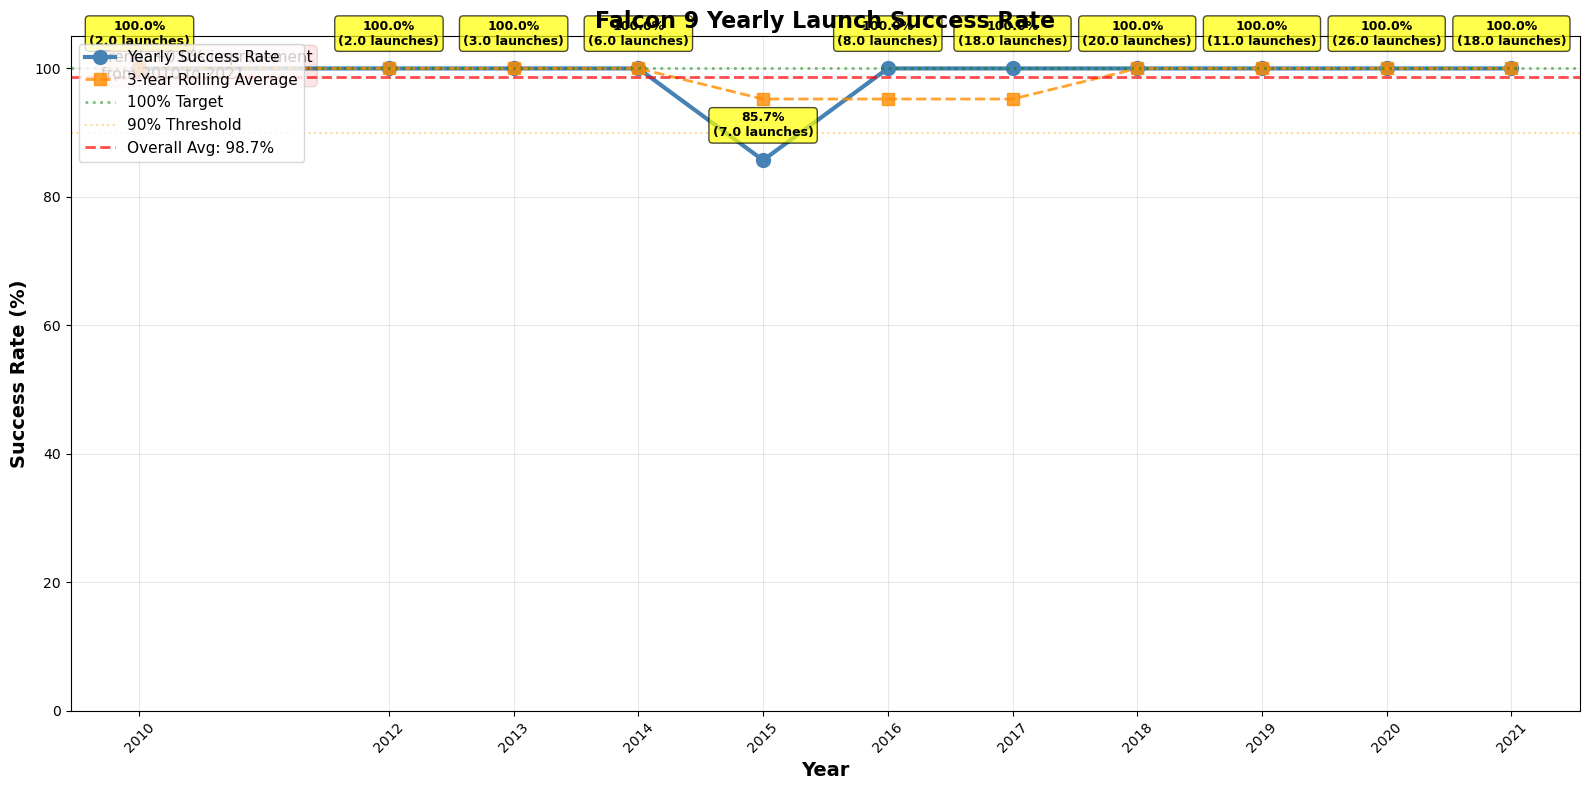


YEARLY SUCCESS RATE STATISTICS
Year     Total      Success    Failure    Success Rate    3-Year Avg     
--------------------------------------------------------------------------------
2010.0   2.0        2.0        0.0        100.0          % 100.0          %
2012.0   2.0        2.0        0.0        100.0          % 100.0          %
2013.0   3.0        3.0        0.0        100.0          % 100.0          %
2014.0   6.0        6.0        0.0        100.0          % 100.0          %
2015.0   7.0        6.0        1.0        85.7           % 95.2           %
2016.0   8.0        8.0        0.0        100.0          % 95.2           %
2017.0   18.0       18.0       0.0        100.0          % 95.2           %
2018.0   20.0       20.0       0.0        100.0          % 100.0          %
2019.0   11.0       11.0       0.0        100.0          % 100.0          %
2020.0   26.0       26.0       0.0        100.0          % 100.0          %
2021.0   18.0       18.0       0.0        100.0      

In [7]:
# -------------------------------
# 11. Line chart of yearly average success rate
# -------------------------------

# Tạo cột Year từ Date
# Hàm trích xuất năm từ date string
def extract_year(date_str):
    if pd.isna(date_str):
        return None
    # Tìm năm trong date string (format thường là "DD Month YYYY")
    year_match = re.search(r'\b(19\d{2}|20\d{2})\b', str(date_str))
    if year_match:
        return int(year_match.group())
    return None

# Áp dụng hàm extract_year
df_wiki['Year'] = df_wiki['Date'].apply(extract_year)

# Lọc dữ liệu Falcon 9 và có Year, Launch outcome hợp lệ
df_yearly = df_wiki[
    df_wiki['Version Booster'].str.contains('F9', case=False, na=False) &
    df_wiki['Year'].notna() &
    df_wiki['Launch outcome'].notna() &
    (df_wiki['Year'] >= 2010)  # Falcon 9 bắt đầu từ 2010
].copy()

# Tính success rate theo năm
yearly_stats = []
for year in sorted(df_yearly['Year'].unique()):
    year_data = df_yearly[df_yearly['Year'] == year]
    total_launches = len(year_data)
    if total_launches > 0:
        successful_launches = len(year_data[
            year_data['Launch outcome'].str.contains('Success', case=False, na=False)
        ])
        success_rate = (successful_launches / total_launches) * 100
        
        yearly_stats.append({
            'Year': year,
            'Total Launches': total_launches,
            'Successful Launches': successful_launches,
            'Success Rate': success_rate
        })

# Tạo DataFrame
df_yearly_stats = pd.DataFrame(yearly_stats)

# Tính rolling average (3-year moving average)
df_yearly_stats['Success Rate Rolling Avg'] = df_yearly_stats['Success Rate'].rolling(window=3, min_periods=1).mean()

# Vẽ line chart
plt.figure(figsize=(16, 8))

# Vẽ line cho success rate theo năm
line1, = plt.plot(df_yearly_stats['Year'], df_yearly_stats['Success Rate'], 
                  marker='o', markersize=10, linewidth=3, 
                  color='steelblue', label='Yearly Success Rate')

# Vẽ line cho rolling average
line2, = plt.plot(df_yearly_stats['Year'], df_yearly_stats['Success Rate Rolling Avg'], 
                  marker='s', markersize=8, linewidth=2, linestyle='--',
                  color='darkorange', alpha=0.8, label='3-Year Rolling Average')

# Thêm số liệu trên các điểm
for idx, row in df_yearly_stats.iterrows():
    # Hiển thị success rate và số lần phóng
    plt.annotate(f'{row["Success Rate"]:.1f}%\n({row["Total Launches"]} launches)', 
                 xy=(row['Year'], row['Success Rate']),
                 xytext=(0, 15),  # offset 15 points
                 textcoords='offset points',
                 ha='center',
                 va='bottom',
                 fontsize=9,
                 fontweight='bold',
                 bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

# Đường 100% success rate
plt.axhline(y=100, color='green', linestyle=':', linewidth=2, alpha=0.5, label='100% Target')

# Đường 90% success rate (threshold tốt)
plt.axhline(y=90, color='orange', linestyle=':', linewidth=1.5, alpha=0.4, label='90% Threshold')

# Đường overall average
overall_avg = df_yearly_stats['Success Rate'].mean()
plt.axhline(y=overall_avg, color='red', linestyle='--', linewidth=2, alpha=0.7, 
            label=f'Overall Avg: {overall_avg:.1f}%')

# Định dạng đồ thị
plt.xlabel('Year', fontsize=14, fontweight='bold')
plt.ylabel('Success Rate (%)', fontsize=14, fontweight='bold')
plt.title('Falcon 9 Yearly Launch Success Rate', fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(loc='upper left', fontsize=11)

# Định dạng trục x
plt.xticks(df_yearly_stats['Year'], rotation=45)
plt.ylim([0, 105])  # Để chừa khoảng trống cho annotation

# Thêm thông tin về trend (sửa lỗi ở đây)
if len(df_yearly_stats) >= 2:
    first_year = df_yearly_stats['Year'].iloc[0]
    last_year = df_yearly_stats['Year'].iloc[-1]
    first_rate = df_yearly_stats['Success Rate'].iloc[0]
    last_rate = df_yearly_stats['Success Rate'].iloc[-1]
    improvement = last_rate - first_rate
    
    # Thêm text box về trend
    trend_text = f'Trend: {improvement:+.1f}% improvement\nfrom {first_year} to {last_year}'
    if improvement > 0:
        trend_color = 'green'
    else:
        trend_color = 'red'
    
    plt.text(0.02, 0.98, trend_text,
             transform=plt.gca().transAxes,
             fontsize=11,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor=trend_color, alpha=0.1))

plt.tight_layout()
plt.show()

# In bảng thống kê chi tiết theo năm
print("\n" + "="*80)
print("YEARLY SUCCESS RATE STATISTICS")
print("="*80)
print(f"{'Year':<8} {'Total':<10} {'Success':<10} {'Failure':<10} {'Success Rate':<15} {'3-Year Avg':<15}")
print("-"*80)

for idx, row in df_yearly_stats.iterrows():
    failures = row['Total Launches'] - row['Successful Launches']
    rolling_avg = row['Success Rate Rolling Avg']
    print(f"{row['Year']:<8} {row['Total Launches']:<10} {row['Successful Launches']:<10} "
          f"{failures:<10} {row['Success Rate']:<15.1f}% {rolling_avg:<15.1f}%")

print("-"*80)
total_launches = df_yearly_stats['Total Launches'].sum()
successful_launches = df_yearly_stats['Successful Launches'].sum()
failures = total_launches - successful_launches
overall_avg_rate = df_yearly_stats['Success Rate'].mean()

print(f"{'Overall':<8} {total_launches:<10} "
      f"{successful_launches:<10} "
      f"{failures:<10} "
      f"{overall_avg_rate:<15.1f}% {'N/A':<15}")

# Tính statistics về trends
print("\n" + "="*80)
print("TREND ANALYSIS")
print("="*80)
if len(df_yearly_stats) >= 2:
    best_year = df_yearly_stats.loc[df_yearly_stats['Success Rate'].idxmax(), 'Year']
    best_rate = df_yearly_stats['Success Rate'].max()
    worst_year = df_yearly_stats.loc[df_yearly_stats['Success Rate'].idxmin(), 'Year']
    worst_rate = df_yearly_stats['Success Rate'].min()
    
    print(f"Best Year: {best_year} ({best_rate:.1f}%)")
    print(f"Worst Year: {worst_year} ({worst_rate:.1f}%)")
    
    # Tính năm bắt đầu có 100% success rate
    perfect_years = df_yearly_stats[df_yearly_stats['Success Rate'] == 100]['Year'].tolist()
    if perfect_years:
        print(f"Years with 100% success rate: {', '.join(map(str, perfect_years))}")
    
    # Tính độ ổn định (standard deviation)
    std_dev = df_yearly_stats['Success Rate'].std()
    variability = '(High variability)' if std_dev > 15 else '(Stable)' if std_dev < 5 else '(Moderate variability)'
    print(f"Standard Deviation: {std_dev:.2f}% {variability}")
    
    # Tính correlation với thời gian
    correlation = df_yearly_stats['Year'].corr(df_yearly_stats['Success Rate'])
    trend_desc = '(Positive trend)' if correlation > 0.3 else '(Negative trend)' if correlation < -0.3 else '(No clear trend)'
    print(f"Correlation with time: {correlation:.3f} {trend_desc}")

In [8]:
# Tìm các launch site duy nhất
unique_launch_sites = df_wiki['Launch Site'].dropna().unique()

print("Unique Launch Sites:")
print("=" * 30)
for site in sorted(unique_launch_sites):
    print(f"- {site}")

print(f"\nTotal: {len(unique_launch_sites)} unique launch sites")

Unique Launch Sites:
- CCAFS
- CCSFS
- Cape Canaveral
- KSC
- VAFB

Total: 5 unique launch sites


In [9]:
# Tìm 5 records có launch site bắt đầu bằng 'CCA'
cca_sites = df_wiki[df_wiki['Launch Site'].str.startswith('CCA', na=False)]

print("First 5 records where Launch Site begins with 'CCA':")
print("=" * 80)
print(cca_sites[['Flight No.', 'Date', 'Launch Site', 'Payload', 'Launch outcome']].head(5))


First 5 records where Launch Site begins with 'CCA':
  Flight No.             Date Launch Site  \
0          1      4 June 2010       CCAFS   
1          2  8 December 2010       CCAFS   
2          3      22 May 2012       CCAFS   
3          4   8 October 2012       CCAFS   
4          5     1 March 2013       CCAFS   

                                Payload Launch outcome  
0  Dragon Spacecraft Qualification Unit        Success  
1                                Dragon        Success  
2                                Dragon        Success  
3                          SpaceX CRS-1        Success  
4                          SpaceX CRS-2        Success  


In [10]:
# Calculate total payload carried by boosters from NASA

# Filter records where Customer contains 'NASA'
nasa_payloads = df_wiki[df_wiki['Customer'].str.contains('NASA', case=False, na=False)].copy()

# Extract numeric payload mass
def extract_numeric_mass(mass_str):
    if pd.isna(mass_str):
        return None
    numbers = re.findall(r'[\d,]+', str(mass_str))
    if numbers:
        clean_number = numbers[0].replace(',', '')
        try:
            return float(clean_number)
        except:
            return None
    return None

nasa_payloads['Payload mass numeric'] = nasa_payloads['Payload mass'].apply(extract_numeric_mass)

# Calculate total payload mass
total_nasa_payload = nasa_payloads['Payload mass numeric'].sum(skipna=True)

print("NASA Payload Summary:")
print("=" * 40)
print(f"Total payload mass: {total_nasa_payload:,.0f} kg")

NASA Payload Summary:
Total payload mass: 124,708 kg


In [11]:
# Calculate average payload mass carried by booster version F9 v1.1

# Filter for booster version F9 v1.1
f9_v11 = df_wiki[df_wiki['Version Booster'].str.contains('F9 v1\.1', case=False, na=False)].copy()

# Extract numeric payload mass
def extract_numeric_mass(mass_str):
    if pd.isna(mass_str):
        return None
    numbers = re.findall(r'[\d,]+', str(mass_str))
    if numbers:
        clean_number = numbers[0].replace(',', '')
        try:
            return float(clean_number)
        except:
            return None
    return None

f9_v11['Payload mass numeric'] = f9_v11['Payload mass'].apply(extract_numeric_mass)

# Calculate statistics
total_launches = len(f9_v11)
valid_payloads = f9_v11['Payload mass numeric'].dropna()
avg_payload = valid_payloads.mean()

print("F9 v1.1 Payload Analysis:")
print("=" * 40)
print(f"Number of launches: {total_launches}")
print(f"Average payload mass: {avg_payload:,.0f} kg")

# Show sample data
if total_launches > 0:
    print(f"\nSample launches ({min(3, total_launches)} of {total_launches}):")
    print("-" * 40)
    sample = f9_v11[['Flight No.', 'Date', 'Payload', 'Payload mass']].head(3)
    print(sample.to_string(index=False))

F9 v1.1 Payload Analysis:
Number of launches: 15
Average payload mass: 2,535 kg

Sample launches (3 of 15):
----------------------------------------
Flight No.              Date   Payload Payload mass
         6 29 September 2013  CASSIOPE       500 kg
         7   3 December 2013     SES-8     3,170 kg
         8    6 January 2014 Thaicom 6     3,325 kg


In [12]:
# Find the date of the first successful landing outcome on ground pad

# Filter for successful ground pad landings
# Assuming "ground pad" could be indicated by terms like "LZ-1", "LZ-2", "Landing Zone", "ground", etc.
ground_landings = df_wiki[
    (df_wiki['Booster landing'].str.contains('Success', case=False, na=False)) &
    (df_wiki['Booster landing'].str.contains('LZ|landing zone|ground|pad', case=False, na=False))
].copy()

# Sort by date to find the first one
if len(ground_landings) > 0:
    # Convert date strings to datetime for proper sorting
    def parse_date(date_str):
        try:
            return pd.to_datetime(date_str, errors='coerce')
        except:
            return None
    
    ground_landings['Date_parsed'] = ground_landings['Date'].apply(parse_date)
    ground_landings_sorted = ground_landings.sort_values('Date_parsed')
    
    first_ground_landing = ground_landings_sorted.iloc[0]
    
    print("First Successful Ground Pad Landing:")
    print("=" * 50)
    print(f"Date: {first_ground_landing['Date']}")
    print(f"Flight No.: {first_ground_landing['Flight No.']}")
    print(f"Booster Version: {first_ground_landing['Version Booster']}")
    print(f"Launch Site: {first_ground_landing['Launch Site']}")
    print(f"Landing Outcome: {first_ground_landing['Booster landing']}")
    
    # Show a few more details
    print(f"\nAdditional successful ground pad landings (first 5):")
    print("-" * 50)
    for i, row in ground_landings_sorted.head(5).iterrows():
        print(f"{row['Date']} - Flight {row['Flight No.']}: {row['Booster landing']}")
else:
    print("No successful ground pad landings found in the dataset")

No successful ground pad landings found in the dataset


In [13]:
# List boosters that successfully landed on drone ship with payload mass 4000-6000 kg

# Filter for drone ship landings with payload mass conditions
drone_ship_success = df_wiki[
    (df_wiki['Booster landing'].str.contains('Success', case=False, na=False)) &
    (df_wiki['Booster landing'].str.contains('OCISLY|ASOG|JRTI|drone|ship', case=False, na=False))
].copy()

# Extract numeric payload mass
def extract_numeric_mass(mass_str):
    if pd.isna(mass_str):
        return None
    numbers = re.findall(r'[\d,]+', str(mass_str))
    if numbers:
        clean_number = numbers[0].replace(',', '')
        try:
            return float(clean_number)
        except:
            return None
    return None

drone_ship_success['Payload mass numeric'] = drone_ship_success['Payload mass'].apply(extract_numeric_mass)

# Filter for payload mass between 4000 and 6000 kg
filtered_boosters = drone_ship_success[
    (drone_ship_success['Payload mass numeric'] > 4000) &
    (drone_ship_success['Payload mass numeric'] < 6000)
]

# Get unique booster names
unique_boosters = filtered_boosters['Version Booster'].dropna().unique()

print("Boosters with successful drone ship landings (payload 4000-6000 kg):")
print("=" * 70)
print(f"Number of qualifying launches: {len(filtered_boosters)}")
print(f"Number of unique booster versions: {len(unique_boosters)}\n")

if len(unique_boosters) > 0:
    print("Booster versions:")
    print("-" * 70)
    for booster in sorted(unique_boosters):
        # Count launches for each booster version
        count = len(filtered_boosters[filtered_boosters['Version Booster'] == booster])
        print(f"• {booster} ({count} launch{'es' if count > 1 else ''})")
    
    print(f"\nDetailed launches ({len(filtered_boosters)} total):")
    print("-" * 70)
    print(f"{'Flight No.':<12} {'Date':<20} {'Booster':<20} {'Payload':<25} {'Payload Mass':<15} {'Drone Ship'}")
    print("-" * 70)
    
    for _, row in filtered_boosters.sort_values('Flight No.').iterrows():
        # Extract drone ship name
        landing_info = str(row['Booster landing'])
        drone_ship = 'Unknown'
        if 'OCISLY' in landing_info:
            drone_ship = 'OCISLY'
        elif 'ASOG' in landing_info:
            drone_ship = 'ASOG'
        elif 'JRTI' in landing_info:
            drone_ship = 'JRTI'
        
        print(f"{row['Flight No.']:<12} {row['Date']:<20} {row['Version Booster'][:18]:<20} "
              f"{row['Payload'][:22]:<25} {row['Payload mass numeric']:<15.0f} {drone_ship}")
else:
    print("No boosters found matching the criteria.")

Boosters with successful drone ship landings (payload 4000-6000 kg):
Number of qualifying launches: 0
Number of unique booster versions: 0

No boosters found matching the criteria.


In [14]:
# Calculate total number of successful and failure mission outcomes

# Filter for Falcon 9 missions only
falcon9_missions = df_wiki[df_wiki['Version Booster'].str.contains('F9', case=False, na=False)]

# Count successful missions
successful = falcon9_missions[
    falcon9_missions['Launch outcome'].str.contains('Success', case=False, na=False)
]

# Count failure missions (including partial failures)
failure_keywords = ['Failure', 'Partial failure', 'Loss', 'Destroyed', 'RUD']
failure_mask = False
for keyword in failure_keywords:
    failure_mask = failure_mask | falcon9_missions['Launch outcome'].str.contains(keyword, case=False, na=False)

failures = falcon9_missions[failure_mask]

# Count other/unknown outcomes
others = falcon9_missions[
    ~falcon9_missions['Launch outcome'].str.contains('Success', case=False, na=False) &
    ~failure_mask
]

# Calculate totals
total_missions = len(falcon9_missions)
success_count = len(successful)
failure_count = len(failures)
other_count = len(others)

# Calculate percentages
success_rate = (success_count / total_missions * 100) if total_missions > 0 else 0
failure_rate = (failure_count / total_missions * 100) if total_missions > 0 else 0
other_rate = (other_count / total_missions * 100) if total_missions > 0 else 0

print("Falcon 9 Mission Outcomes:")
print("=" * 60)
print(f"Total missions analyzed: {total_missions}")
print("\nOutcome Breakdown:")
print("-" * 60)
print(f"Successful missions: {success_count:>4} ({success_rate:5.1f}%)")
print(f"Failed missions:     {failure_count:>4} ({failure_rate:5.1f}%)")
print(f"Other/Unknown:       {other_count:>4} ({other_rate:5.1f}%)")

# Show sample of failures if any
if failure_count > 0:
    print(f"\nFailure Details ({failure_count} failures):")
    print("-" * 60)
    print(f"{'Flight No.':<12} {'Date':<15} {'Payload':<25} {'Outcome'}")
    print("-" * 60)
    for _, row in failures.sort_values('Flight No.').head(10).iterrows():
        print(f"{row['Flight No.']:<12} {row['Date']:<15} {str(row['Payload'])[:23]:<25} {row['Launch outcome']}")
    
    if failure_count > 10:
        print(f"... and {failure_count - 10} more failures")

# Success rate timeline (if year data is available)
if 'Year' in falcon9_missions.columns and len(falcon9_missions['Year'].dropna()) > 0:
    yearly_success = []
    for year in sorted(falcon9_missions['Year'].dropna().unique()):
        year_missions = falcon9_missions[falcon9_missions['Year'] == year]
        year_success = len(year_missions[
            year_missions['Launch outcome'].str.contains('Success', case=False, na=False)
        ])
        year_total = len(year_missions)
        if year_total > 0:
            yearly_success.append((year, year_success/year_total*100))
    
    if yearly_success:
        best_year = max(yearly_success, key=lambda x: x[1])
        worst_year = min(yearly_success, key=lambda x: x[1])
        
        print(f"\nSuccess Rate Analysis:")
        print("-" * 60)
        print(f"Best year: {best_year[0]} ({best_year[1]:.1f}% success rate)")
        print(f"Worst year: {worst_year[0]} ({worst_year[1]:.1f}% success rate)")

Falcon 9 Mission Outcomes:
Total missions analyzed: 121

Outcome Breakdown:
------------------------------------------------------------
Successful missions:  120 ( 99.2%)
Failed missions:        1 (  0.8%)
Other/Unknown:          0 (  0.0%)

Failure Details (1 failures):
------------------------------------------------------------
Flight No.   Date            Payload                   Outcome
------------------------------------------------------------
19           28 June 2015    SpaceX CRS-7              Failure

Success Rate Analysis:
------------------------------------------------------------
Best year: 2010 (100.0% success rate)
Worst year: 2015 (85.7% success rate)


In [15]:
# Find boosters that carried the maximum payload mass

# Extract numeric payload mass
def extract_numeric_mass(mass_str):
    if pd.isna(mass_str):
        return None
    numbers = re.findall(r'[\d,]+', str(mass_str))
    if numbers:
        clean_number = numbers[0].replace(',', '')
        try:
            return float(clean_number)
        except:
            return None
    return None

df_wiki['Payload mass numeric'] = df_wiki['Payload mass'].apply(extract_numeric_mass)

# Find the maximum payload mass
max_payload = df_wiki['Payload mass numeric'].max()

# Find all boosters that carried this maximum payload
max_payload_boosters = df_wiki[df_wiki['Payload mass numeric'] == max_payload]

print("Boosters with Maximum Payload Mass:")
print("=" * 70)
print(f"Maximum payload mass: {max_payload:,.0f} kg\n")

print(f"Number of missions with maximum payload: {len(max_payload_boosters)}")
print(f"Number of unique booster versions: {len(max_payload_boosters['Version Booster'].unique())}\n")

print("Missions with Maximum Payload:")
print("-" * 70)
print(f"{'Flight No.':<12} {'Date':<15} {'Booster':<20} {'Payload':<25} {'Payload Mass':<15} {'Orbit':<15}")
print("-" * 70)

for _, row in max_payload_boosters.sort_values('Flight No.').iterrows():
    print(f"{row['Flight No.']:<12} {row['Date']:<15} {row['Version Booster'][:18]:<20} "
          f"{row['Payload'][:23]:<25} {row['Payload mass numeric']:<15,.0f} {row['Orbit'][:13]:<15}")

# Also find top 5 heaviest payloads for context
print(f"\n\nTop 5 Heaviest Payloads:")
print("-" * 70)
print(f"{'Rank':<6} {'Flight No.':<12} {'Date':<15} {'Booster':<20} {'Payload':<25} {'Mass (kg)':<12}")
print("-" * 70)

# Get unique payload masses sorted descending
unique_payloads = df_wiki[['Flight No.', 'Date', 'Version Booster', 'Payload', 'Payload mass numeric']].dropna()
unique_payloads = unique_payloads.sort_values('Payload mass numeric', ascending=False)

for i, (_, row) in enumerate(unique_payloads.head(5).iterrows(), 1):
    print(f"{i:<6} {row['Flight No.']:<12} {row['Date']:<15} {row['Version Booster'][:18]:<20} "
          f"{row['Payload'][:23]:<25} {row['Payload mass numeric']:<12,.0f}")

# Group by booster version to see which versions carried heavy payloads
print(f"\n\nBooster Versions and Their Maximum Payloads:")
print("-" * 70)
print(f"{'Booster Version':<25} {'Max Payload (kg)':<20} {'Missions':<10}")
print("-" * 70)

booster_stats = df_wiki.groupby('Version Booster')['Payload mass numeric'].agg(['max', 'count']).reset_index()
booster_stats = booster_stats.sort_values('max', ascending=False)

for _, row in booster_stats.head(10).iterrows():
    if pd.notna(row['max']):
        print(f"{row['Version Booster'][:24]:<25} {row['max']:<20,.0f} {row['count']:<10}")

Boosters with Maximum Payload Mass:
Maximum payload mass: 15,600 kg

Number of missions with maximum payload: 24
Number of unique booster versions: 12

Missions with Maximum Payload:
----------------------------------------------------------------------
Flight No.   Date            Booster              Payload                   Payload Mass    Orbit          
----------------------------------------------------------------------
100          25 November 2020 F9 B5 ♺[             Starlink                  15,600          LEO            
105          20 January 2021 F9 B5B1051.8609      Starlink                  15,600          LEO            
107          4 February 2021 F9 B5 ♺[             Starlink                  15,600          LEO            
108          16 February 2021 F9 B5 ♺              Starlink                  15,600          LEO            
109          4 March 2021    F9 B5 ♺[             Starlink                  15,600          LEO            
110          11 March 202

In [16]:
# Find failed landing outcomes in drone ship for year 2015

# First, extract year from Date
def extract_year(date_str):
    if pd.isna(date_str):
        return None
    year_match = re.search(r'\b(20\d{2})\b', str(date_str))
    if year_match:
        return int(year_match.group())
    return None

df_wiki['Year'] = df_wiki['Date'].apply(extract_year)

# Filter for year 2015, drone ship landings, and failed outcomes
failed_drone_2015 = df_wiki[
    (df_wiki['Year'] == 2015) &
    (df_wiki['Booster landing'].str.contains('drone|ship|OCISLY|ASOG|JRTI', case=False, na=False)) &
    (df_wiki['Booster landing'].str.contains('fail|lost|destroy|crash|no attempt', case=False, na=False))
].copy()

print("Failed Drone Ship Landings in 2015:")
print("=" * 80)
print(f"Number of failed drone ship landings in 2015: {len(failed_drone_2015)}\n")

if len(failed_drone_2015) > 0:
    print("Detailed List:")
    print("-" * 80)
    print(f"{'Flight No.':<12} {'Date':<20} {'Booster Version':<25} {'Launch Site':<25} {'Landing Outcome':<30}")
    print("-" * 80)
    
    for _, row in failed_drone_2015.sort_values('Flight No.').iterrows():
        # Clean up landing outcome for display
        landing_outcome = str(row['Booster landing']).replace('\n', ' ').strip()
        if len(landing_outcome) > 28:
            landing_outcome = landing_outcome[:25] + "..."
        
        print(f"{row['Flight No.']:<12} {row['Date']:<20} {row['Version Booster'][:23]:<25} "
              f"{row['Launch Site'][:23]:<25} {landing_outcome:<30}")
    
    # Additional analysis
    print(f"\n\nAnalysis of 2015 Drone Ship Landing Attempts:")
    print("-" * 80)
    
    # Get all 2015 drone ship attempts for context
    all_drone_2015 = df_wiki[
        (df_wiki['Year'] == 2015) &
        (df_wiki['Booster landing'].str.contains('drone|ship|OCISLY|ASOG|JRTI', case=False, na=False))
    ]
    
    success_drone_2015 = all_drone_2015[
        all_drone_2015['Booster landing'].str.contains('success', case=False, na=False)
    ]
    
    total_drone_attempts_2015 = len(all_drone_2015)
    success_count_2015 = len(success_drone_2015)
    failure_count_2015 = len(failed_drone_2015)
    
    print(f"Total drone ship landing attempts in 2015: {total_drone_attempts_2015}")
    print(f"Successful drone ship landings in 2015: {success_count_2015}")
    print(f"Failed drone ship landings in 2015: {failure_count_2015}")
    
    if total_drone_attempts_2015 > 0:
        success_rate = (success_count_2015 / total_drone_attempts_2015) * 100
        failure_rate = (failure_count_2015 / total_drone_attempts_2015) * 100
        print(f"Success rate: {success_rate:.1f}%")
        print(f"Failure rate: {failure_rate:.1f}%")
    
    # Show booster versions used in 2015 drone ship attempts
    print(f"\nBooster versions used in 2015 drone ship attempts:")
    print("-" * 40)
    booster_counts = all_drone_2015['Version Booster'].value_counts()
    for booster, count in booster_counts.items():
        print(f"• {booster}: {count} attempt{'s' if count > 1 else ''}")
    
    # Show launch sites used
    print(f"\nLaunch sites for 2015 drone ship attempts:")
    print("-" * 40)
    site_counts = all_drone_2015['Launch Site'].value_counts()
    for site, count in site_counts.items():
        print(f"• {site}: {count} launch{'es' if count > 1 else ''}")
        
else:
    print("No failed drone ship landings found for 2015.")
    
    # But let's check what drone ship activities did happen in 2015
    print("\nChecking for any drone ship activities in 2015...")
    any_drone_2015 = df_wiki[
        (df_wiki['Year'] == 2015) &
        (df_wiki['Booster landing'].str.contains('drone|ship|OCISLY|ASOG|JRTI', case=False, na=False))
    ]
    
    if len(any_drone_2015) > 0:
        print(f"\nDrone ship activities in 2015 (all outcomes):")
        print("-" * 60)
        for _, row in any_drone_2015.sort_values('Flight No.').iterrows():
            print(f"Flight {row['Flight No.']}: {row['Date']} - {row['Booster landing']}")

Failed Drone Ship Landings in 2015:
Number of failed drone ship landings in 2015: 0

No failed drone ship landings found for 2015.

Checking for any drone ship activities in 2015...


In [ ]:
# Rank landing outcomes between 2010-06-04 and 2017-03-20

# Convert Date column to datetime for comparison
def parse_date(date_str):
    try:
        return pd.to_datetime(date_str, errors='coerce')
    except:
        return None

df_wiki['Date_parsed'] = df_wiki['Date'].apply(parse_date)

# Define date range
start_date = pd.to_datetime('2010-06-04')
end_date = pd.to_datetime('2017-03-20')

# Filter data for the date range
date_range_data = df_wiki[
    (df_wiki['Date_parsed'] >= start_date) &
    (df_wiki['Date_parsed'] <= end_date)
]

# Filter for Falcon 9 missions only
falcon9_date_range = date_range_data[
    date_range_data['Version Booster'].str.contains('F9', case=False, na=False)
]

# Clean and categorize landing outcomes
def categorize_landing_outcome(outcome_str):
    if pd.isna(outcome_str):
        return 'No landing attempt'
    
    outcome = str(outcome_str).lower()
    
    if 'success' in outcome:
        if 'drone' in outcome or 'ship' in outcome or 'ocisly' in outcome:
            return 'Success (drone ship)'
        elif 'lz' in outcome or 'landing zone' in outcome or 'ground' in outcome:
            return 'Success (ground pad)'
        elif 'rtls' in outcome:
            return 'Success (RTLS)'
        else:
            return 'Success (other/unspecified)'
    
    elif 'fail' in outcome or 'lost' in outcome or 'crash' in outcome or 'destroy' in outcome:
        if 'drone' in outcome or 'ship' in outcome or 'ocisly' in outcome:
            return 'Failure (drone ship)'
        elif 'lz' in outcome or 'landing zone' in outcome or 'ground' in outcome:
            return 'Failure (ground pad)'
        elif 'rtls' in outcome:
            return 'Failure (RTLS)'
        else:
            return 'Failure (other/unspecified)'
    
    elif 'expended' in outcome or 'no recovery' in outcome:
        return 'Expended (no landing attempt)'
    
    elif 'planned' in outcome or 'scheduled' in outcome:
        return 'Planned (future)'
    
    else:
        return 'Other/Unknown'

# Apply categorization
falcon9_date_range['Landing Category'] = falcon9_date_range['Booster landing'].apply(categorize_landing_outcome)

# Count landing outcomes
landing_counts = falcon9_date_range['Landing Category'].value_counts().reset_index()
landing_counts.columns = ['Landing Outcome', 'Count']

# Calculate percentages
total_landings = landing_counts['Count'].sum()
landing_counts['Percentage'] = (landing_counts['Count'] / total_landings * 100).round(1)

# Sort in descending order by count
landing_counts = landing_counts.sort_values('Count', ascending=False)

print("Landing Outcomes Ranking (2010-06-04 to 2017-03-20):")
print("=" * 80)
print(f"Date Range: {start_date.date()} to {end_date.date()}")
print(f"Total Falcon 9 missions in period: {len(falcon9_date_range)}")
print(f"Total landing outcomes analyzed: {total_landings}\n")

print("Ranking (Descending Order):")
print("-" * 80)
print(f"{'Rank':<6} {'Landing Outcome':<35} {'Count':<10} {'Percentage':<10}")
print("-" * 80)

for rank, (_, row) in enumerate(landing_counts.iterrows(), 1):
    print(f"{rank:<6} {row['Landing Outcome']:<35} {row['Count']:<10} {row['Percentage']:<10}%")

# Additional detailed breakdown
print(f"\n\nDetailed Breakdown by Year:")
print("=" * 80)

# Group by year and landing category
falcon9_date_range['Year'] = falcon9_date_range['Date_parsed'].dt.year
yearly_breakdown = falcon9_date_range.groupby(['Year', 'Landing Category']).size().unstack(fill_value=0)

print(yearly_breakdown.to_string())

# Timeline of first occurrences
print(f"\n\nFirst Occurrences of Key Landing Outcomes:")
print("=" * 80)

key_outcomes = ['Success (drone ship)', 'Success (ground pad)', 'Failure (drone ship)', 'Failure (ground pad)']
first_occurrences = []

for outcome in key_outcomes:
    missions = falcon9_date_range[falcon9_date_range['Landing Category'] == outcome]
    if len(missions) > 0:
        first_mission = missions.sort_values('Date_parsed').iloc[0]
        first_occurrences.append({
            'Outcome': outcome,
            'First Date': first_mission['Date_parsed'].date(),
            'Flight No.': first_mission['Flight No.'],
            'Mission': first_mission['Payload'][:30] + '...' if len(str(first_mission['Payload'])) > 30 else first_mission['Payload']
        })

if first_occurrences:
    print(f"{'Outcome':<25} {'First Date':<15} {'Flight No.':<12} {'Mission'}")
    print("-" * 80)
    for occ in sorted(first_occurrences, key=lambda x: x['First Date']):
        print(f"{occ['Outcome']:<25} {occ['First Date']:<15} {occ['Flight No.']:<12} {occ['Mission']}")

# Success rate analysis
print(f"\n\nSuccess Rate Analysis:")
print("=" * 80)

success_categories = [cat for cat in landing_counts['Landing Outcome'] if 'Success' in cat]
failure_categories = [cat for cat in landing_counts['Landing Outcome'] if 'Failure' in cat]

total_success = landing_counts[landing_counts['Landing Outcome'].isin(success_categories)]['Count'].sum()
total_failure = landing_counts[landing_counts['Landing Outcome'].isin(failure_categories)]['Count'].sum()
total_attempts = total_success + total_failure

if total_attempts > 0:
    overall_success_rate = (total_success / total_attempts * 100)
    print(f"Total landing attempts: {total_attempts}")
    print(f"Successful landings: {total_success} ({overall_success_rate:.1f}%)")
    print(f"Failed landings: {total_failure} ({100-overall_success_rate:.1f}%)")
    
    # Drone ship specific
    drone_success = landing_counts[landing_counts['Landing Outcome'] == 'Success (drone ship)']['Count'].sum()
    drone_failure = landing_counts[landing_counts['Landing Outcome'] == 'Failure (drone ship)']['Count'].sum()
    drone_total = drone_success + drone_failure
    
    if drone_total > 0:
        drone_success_rate = (drone_success / drone_total * 100)
        print(f"\nDrone Ship Landings:")
        print(f"  Attempts: {drone_total}")
        print(f"  Success rate: {drone_success_rate:.1f}%")
    
    # Ground pad specific
    ground_success = landing_counts[landing_counts['Landing Outcome'] == 'Success (ground pad)']['Count'].sum()
    ground_failure = landing_counts[landing_counts['Landing Outcome'] == 'Failure (ground pad)']['Count'].sum()
    ground_total = ground_success + ground_failure
    
    if ground_total > 0:
        ground_success_rate = (ground_success / ground_total * 100)
        print(f"\nGround Pad Landings:")
        print(f"  Attempts: {ground_total}")
        print(f"  Success rate: {ground_success_rate:.1f}%")